In [1]:
# import library
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# directory and categries
DIRECTORY = r"C:\Users\Vipul Singh\Desktop\dataset"
CATEGORIES = {"with_mask":1, "without_mask":0}

In [3]:
# loading data from folder
data = []
labels = []
for label in CATEGORIES:
    file_path = DIRECTORY+ "\\" +label
    for img in os.listdir(file_path):
        img_path = os.path.join(file_path, img)
        img = load_img(img_path, target_size = (224, 224))
        img = img_to_array(img)
        img = preprocess_input(img)
        data.append(img)
        labels.append(CATEGORIES[label])

c:\users\vipul singh\anaconda3\envs\gputest\lib\site-packages\PIL\Image.py:952: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [4]:
# generate one-hot vactor for labels
labels = to_categorical(labels)

# convert into array
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [5]:
# train and validation split
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size  = 0.20)

In [6]:
# data augmentation
datagen = ImageDataGenerator(width_shift_range=0.2,height_shift_range=0.2,rotation_range=20, shear_range=0.15,horizontal_flip=True, fill_mode="nearest", zoom_range=0.15,)

In [7]:
# load basemodel(mobileNetv2)
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

# adiing layers to base model for fine-tuning
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# creating model
model = Model(inputs=baseModel.input, outputs=headModel)

c:\users\vipul singh\anaconda3\envs\gputest\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [8]:
# freeze layers of basemodel
for layer in baseModel.layers:
    layer.trainable = False

In [9]:
EPOCHS = 20
BS = 32
INIT_LR = 1e-4

In [10]:
# creating optimizer
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

In [11]:
# compile model
model.compile(loss="binary_crossentropy", optimizer=opt , metrics=["accuracy"])

In [12]:
# train model(fine-tuning by using data-augmentation)
History = model.fit(datagen.flow(x_train, y_train, batch_size=BS), steps_per_epoch=len(x_train) // BS, validation_data=(x_test, y_test), validation_steps=len(x_test) // BS, epochs=EPOCHS)

Train for 95 steps, validate on 767 samples
Epoch 1/20
95/95 [==============================] - 42s 444ms/step - loss: 0.5322 - accuracy: 0.7446 - val_loss: 0.4343 - val_accuracy: 0.7880
Epoch 2/20
95/95 [==============================] - 35s 367ms/step - loss: 0.2857 - accuracy: 0.8889 - val_loss: 0.3435 - val_accuracy: 0.8397
Epoch 3/20
95/95 [==============================] - 34s 362ms/step - loss: 0.2204 - accuracy: 0.9140 - val_loss: 0.3010 - val_accuracy: 0.8655
Epoch 4/20
95/95 [==============================] - 34s 361ms/step - loss: 0.1898 - accuracy: 0.9295 - val_loss: 0.2640 - val_accuracy: 0.8832
Epoch 5/20
95/95 [==============================] - 34s 361ms/step - loss: 0.1594 - accuracy: 0.9420 - val_loss: 0.3365 - val_accuracy: 0.8641
Epoch 6/20
95/95 [==============================] - 34s 363ms/step - loss: 0.1620 - accuracy: 0.9403 - val_loss: 0.3524 - val_accuracy: 0.8587
Epoch 7/20
95/95 [==============================] - 34s 361ms/step - loss: 0.1397 - accuracy: 0.95

In [13]:
# predict the x_test
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

In [14]:
# print classification report
print(classification_report(y_test.argmax(axis=1), y_pred, target_names=CATEGORIES))

              precision    recall  f1-score   support

   with_mask       0.85      0.99      0.91       382
without_mask       0.99      0.83      0.90       385

    accuracy                           0.91       767
   macro avg       0.92      0.91      0.91       767
weighted avg       0.92      0.91      0.91       767



In [15]:
# save the model
model.save("mask_detector.model", save_format="h5")

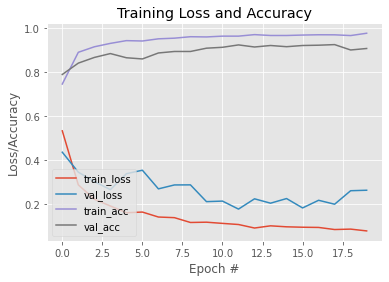

In [16]:
# plot accuracy and loss
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), History.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), History.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), History.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), History.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("No of Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(3)
plt.savefig("plot.png")